In [1]:
import os
import chess
import numpy as np
import pandas as pd
import keras

In [2]:
#Load FEN and Evaluation value data into a pandas dataframe

os.chdir('/Users/Nasif/Chess AI')
df = pd.read_csv('random_evals.csv')

nOfSamples = 10000 #Number of samples to test the NN with

df=df.drop(df.index[nOfSamples:]) 

#df.dtypes

FEN           object
Evaluation    object
dtype: object

In [3]:
#One hot encoding of chess pieces dictionary
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
} 

def make_matrix(fenString): #Converts FEN data to a ASCII representation of the chess board
    board = chess.Board()
    #set up board from FEN data
    board.set_fen(fenString)
    fen = board.fen()
    tempArr1 = [] 
    #After FEN data inputted in board in chess library, extract the piece position information
    pieces = fen.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        tempArr2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    tempArr2.append('.')
            else:
                tempArr2.append(thing)
        tempArr1.append(tempArr2)
    return tempArr1

def translate(matrix,chess_dict): #Converts ASCII representation to matrix for NN input
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

#print(translate(make_matrix('rnbqkb1r/pppppppp/B4n2/8/4P3/8/PPPP1PPP/RNBQK1NR b KQkq - 2 2'),chess_dict))

[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 

In [4]:
#Process evaluation data for NN Input

def NormalizeData(data): #normalize evaluation data 
    normDataSet = []
    minY = (np.min(data))
    maxY = (np.max(data))
    for x in data:
        temp = (((x - minY)/(maxY-minY)))
        normDataSet.append(temp)
    return normDataSet,data

def deNormalizeData(arr,minY,maxY): #DeNormalize to check against real evaluation score
    data = []
    for x in arr:
        y = (x*(maxY-minY)+minY)
        data.append(y)
    return data

def data_setup():
    testX = []
    testY = []
    i = 0
    while (i<nOfSamples):
        matrix = make_matrix(df.iloc[i,0])
        trans_matrix = translate(matrix,chess_dict)
        temp = df.iloc[i,1]
        if '#' not in temp:
            testY.append(int(temp))
            testX.append(trans_matrix)
        i += 1
    return testX,testY

testX,testY = data_setup()
del[df] #delete dataframe after data extraction to save memory in computer
testY,mainY = NormalizeData(testY)

In [5]:
model = keras.models.load_model('test2.h5') #Load and evaluate model to see loss and mean absolte error
score = model.evaluate(testX,testY,verbose=1)
print(f'Test loss: {score[0]}')

283/283 [==============================] - 4s 14ms/step - loss: 0.0030 - mae: 0.0345
Test loss: 0.003035562578588724


In [6]:
predict_vals = model.predict(testX,verbose=1)  #Predict evaluation values given test input FEN data

283/283 [==============================] - 4s 13ms/step


In [7]:
#Process data for representation
arr1 = []
i = 0
while (i <9000):
    diff = testY[i] - predict_vals[i]
    arr1.append(diff)
    i += 1
    

Text(0, 0.5, 'Diff between actual val and predicted val')

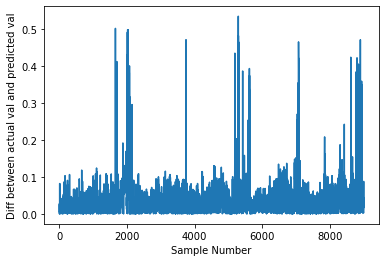

In [8]:
import matplotlib.pyplot as pyplot
import random
sampleN = 9000
y = []
i = 0

#Get Difference values which is always positive so we only take absolute values of the differences for visual representation and analysis
for i in range(sampleN):
    y.append(abs(arr1[i]))

#Plot graph
x = list(range(0,sampleN))
pyplot.plot(x,y) 
pyplot.xlabel("Sample Number")
pyplot.ylabel("Diff between actual val and predicted val")

(array([391., 412., 392., 368., 375., 348., 400., 364., 312., 325., 312.,
        349., 332., 339., 254., 236., 245., 240., 201., 190., 178., 163.,
        154., 159., 119., 135., 133., 104.,  96.,  91.,  93.,  90.,  70.,
         87.,  68.,  60.,  47.,  57.,  39.,  43.,  42.,  34.,  32.,  34.,
         36.,  40.,  33.,  32.,  20.,  20.]),
 array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
        0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
        0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
        0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
        0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
        0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  ]),
 <BarContainer object of 50 artists>)

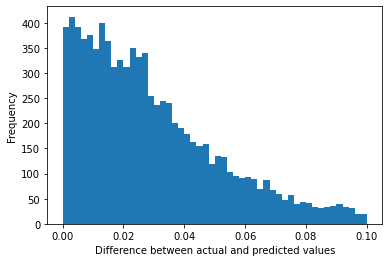

In [28]:
roundY = []

#Plot Histogram
for val in y:
    temp = round(float(val),300) #rounded to 3 decimal points for histogram representation
    roundY.append(temp)
pyplot.ylabel("Frequency")
pyplot.xlabel("Difference between actual and predicted values")
pyplot.hist(roundY,bins=50,range=(0,0.1))

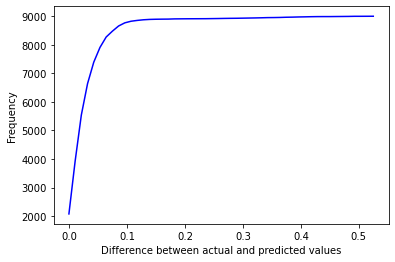

In [33]:
values, base = np.histogram(roundY, bins=50)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
pyplot.ylabel("Frequency")
pyplot.xlabel("Difference between actual and predicted values")
pyplot.plot(base[:-1], cumulative, c='blue')


In [18]:
len(roundY)
restVals = []
for tempVal in roundY:
    if tempVal <= 0.1:
        restVals.append(tempVal)
print("Number of Samples less than or equal to 0.1 = " + str(len(restVals)))

Number of Samples less than or equal to 0.1 = 8694


In [27]:
import statistics as sts

#Print Statistical values from difference dataset
print("Mean Difference = " + str(sts.mean(roundY)))
print("Median Difference = " + str(sts.median(roundY)))
print("Mode Difference = " + str(sts.mode(roundY)))
print("Population Standard Deviation = " + str(sts.pstdev(roundY)))


Mean Difference = 0.03455917353762521
Median Difference = 0.024913206696510315
Mode Difference = 0.031095147132873535
Population Standard Deviation = 0.04305645336908341


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 2048)              1574912   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0